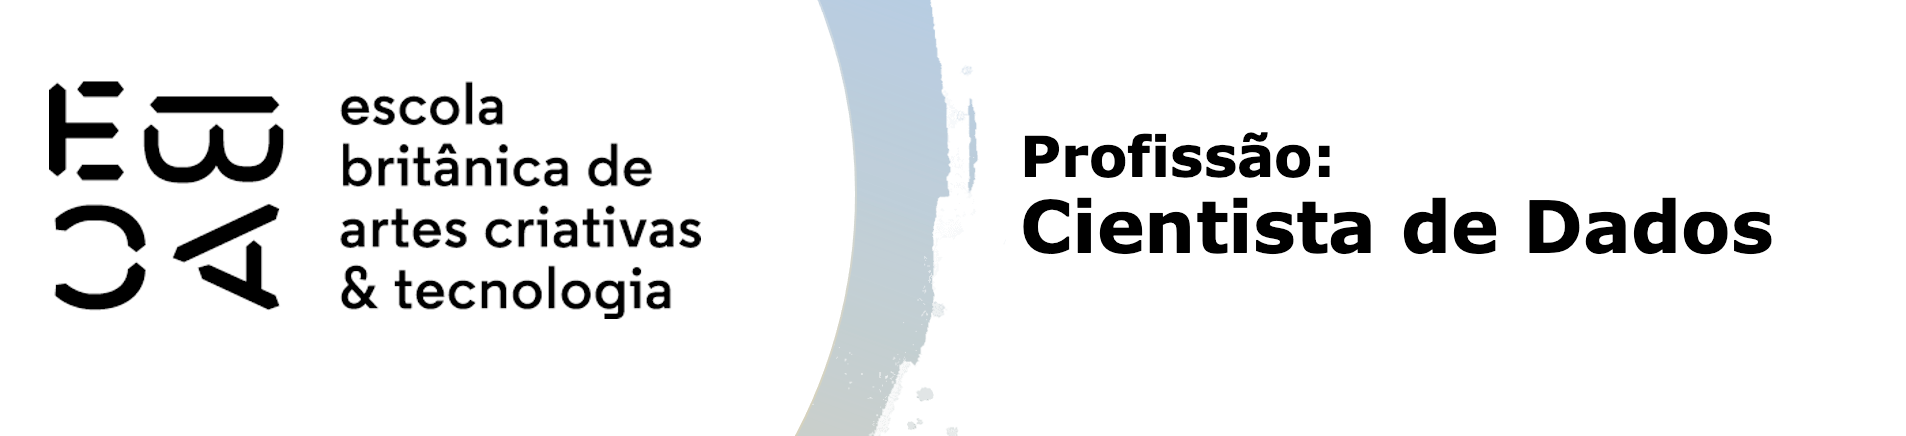

# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
df = pd.read_pickle('base_nfp.pkl')
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes


## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [5]:
df['Data Emissão'] = pd.to_datetime(df['Data Emissão'], errors='coerce')

df['dia_semana'] = df['Data Emissão'].dt.day_name()        
df['fim_de_semana'] = df['Data Emissão'].dt.weekday >= 5    
df['dia_mes'] = df['Data Emissão'].dt.day                   
df['mes'] = df['Data Emissão'].dt.month                     
df['trimestre'] = df['Data Emissão'].dt.quarter            
df['ano'] = df['Data Emissão'].dt.year                     

quantis_list = [5, 10, 20, 50]

for q in quantis_list:
    nome_col = f'valor_nf_q{q}'
    df[nome_col] = pd.qcut(df['Valor NF'], q, duplicates='drop') 


print(df[['Valor NF', 'dia_semana', 'fim_de_semana', 'dia_mes', 'mes', 'trimestre', 'ano'] + [f'valor_nf_q{q}' for q in quantis_list]].head())


   Valor NF dia_semana  fim_de_semana  dia_mes  mes  trimestre   ano  \
0     24.68     Friday          False       30    6          2  2017   
1     50.00     Friday          False       30    6          2  2017   
2     27.00     Friday          False       30    6          2  2017   
3    111.50     Friday          False       30    6          2  2017   
4    125.00     Friday          False       30    6          2  2017   

      valor_nf_q5    valor_nf_q10      valor_nf_q20     valor_nf_q50  
0  (13.36, 28.61]  (20.29, 28.61]     (24.5, 28.61]   (23.62, 25.14]  
1   (28.61, 55.0]   (38.88, 55.0]    (46.028, 55.0]    (48.0, 50.72]  
2  (13.36, 28.61]  (20.29, 28.61]     (24.5, 28.61]    (26.9, 28.61]  
3  (55.0, 131.36]  (81.8, 131.36]  (101.48, 131.36]  (107.04, 119.5]  
4  (55.0, 131.36]  (81.8, 131.36]  (101.48, 131.36]  (119.5, 131.36]  


## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [7]:

def calcula_woe_iv(df, var, target):
    """
    Calcula WOE e IV para a variável categórica var em relação ao target binário.
    df: DataFrame
    var: nome da variável categórica
    target: nome da variável alvo binária (0/1)
    Retorna: DataFrame com WOE por categoria e o IV total.
    """
    df2 = df[[var, target]].copy()
    
    grouped = df2.groupby(var)[target].agg(['sum', 'count'])
    grouped['non_event'] = grouped['count'] - grouped['sum']
    
    total_event = grouped['sum'].sum()
    total_non_event = grouped['non_event'].sum()
    
    grouped['prop_event'] = grouped['sum'] / total_event
    grouped['prop_non_event'] = grouped['non_event'] / total_non_event
    
    grouped['prop_event'] = grouped['prop_event'].replace(0, 0.0001)
    grouped['prop_non_event'] = grouped['prop_non_event'].replace(0, 0.0001)
    
    grouped['WOE'] = np.log(grouped['prop_event'] / grouped['prop_non_event'])
    
    grouped['IV_component'] = (grouped['prop_event'] - grouped['prop_non_event']) * grouped['WOE']
    iv = grouped['IV_component'].sum()
    
    return grouped[['prop_event', 'prop_non_event', 'WOE', 'IV_component']], iv

In [8]:
df['evento'] = (df['Retorno'] > 0).astype(int)

variaveis = [
    'dia_semana',
    'fim_de_semana',
    'dia_mes',
    'mes',
    'trimestre',
    'ano',
    'valor_nf_q5',
    'valor_nf_q10',
    'valor_nf_q20',
    'valor_nf_q50'
]

resultados_iv = {}

for var in variaveis:
    tabela_woe, iv = calcula_woe_iv(df, var, 'evento')
    resultados_iv[var] = {'IV': iv, 'WOE_table': tabela_woe}
    print(f'Variável: {var} - IV: {iv:.4f}\n')

Variável: dia_semana - IV: 0.0069

Variável: fim_de_semana - IV: 0.0043

Variável: dia_mes - IV: 0.0437

Variável: mes - IV: 0.0278

Variável: trimestre - IV: 0.0115

Variável: ano - IV: 0.0418

Variável: valor_nf_q5 - IV: 0.0567

Variável: valor_nf_q10 - IV: 0.1066

Variável: valor_nf_q20 - IV: 0.1245

Variável: valor_nf_q50 - IV: 0.1523



C:\Users\shinoki\AppData\Local\Temp\ipykernel_5952\220189923.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df2.groupby(var)[target].agg(['sum', 'count'])
C:\Users\shinoki\AppData\Local\Temp\ipykernel_5952\220189923.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df2.groupby(var)[target].agg(['sum', 'count'])
C:\Users\shinoki\AppData\Local\Temp\ipykernel_5952\220189923.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future defa

## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

In [ ]:
# A variável valor_nf_q50, que divide o valor da nota em 50 categorias, teve o maior IV, mostrando que tem um poder médio a forte para prever o retorno positivo. Quando aumentamos o número de categorias na divisão do valor da nota, de 5 até 50, o IV também aumenta, o que indica que uma divisão mais detalhada ajuda a entender melhor a relação com o retorno maior que zero. Entre as variáveis temporais, as que tiveram mais destaque foram o dia do mês e o ano, com IVs de 0,0437 e 0,0418 respectivamente, mostrando um poder preditivo fraco a médio. Já as variáveis dia da semana, fim de semana, mês e trimestre tiveram IVs muito baixos, abaixo de 0,03, o que indica que têm pouco poder para diferenciar as notas que geram retorno.

## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

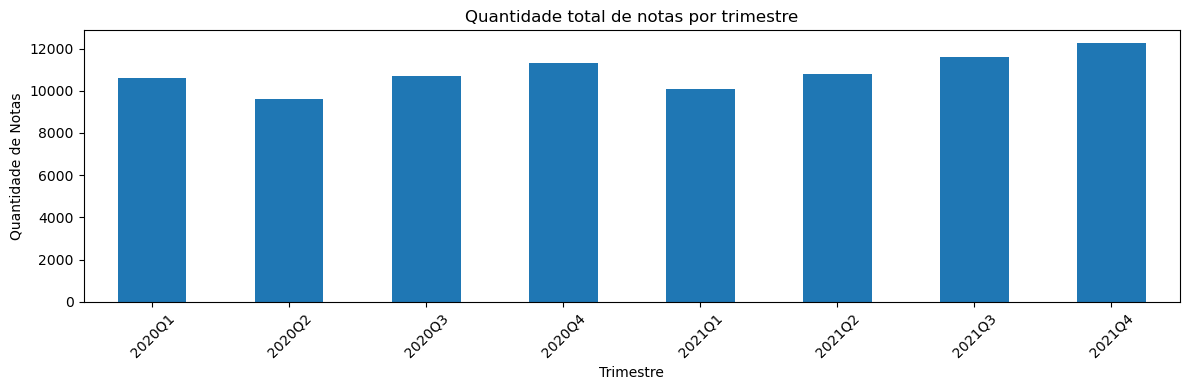

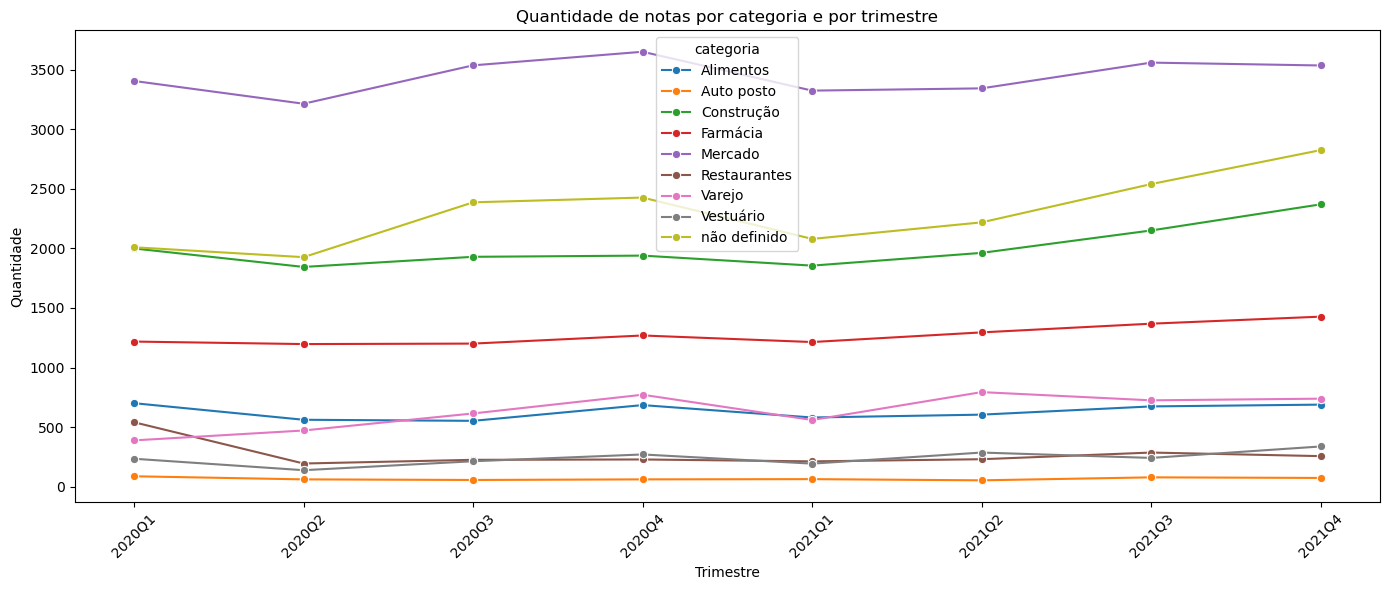

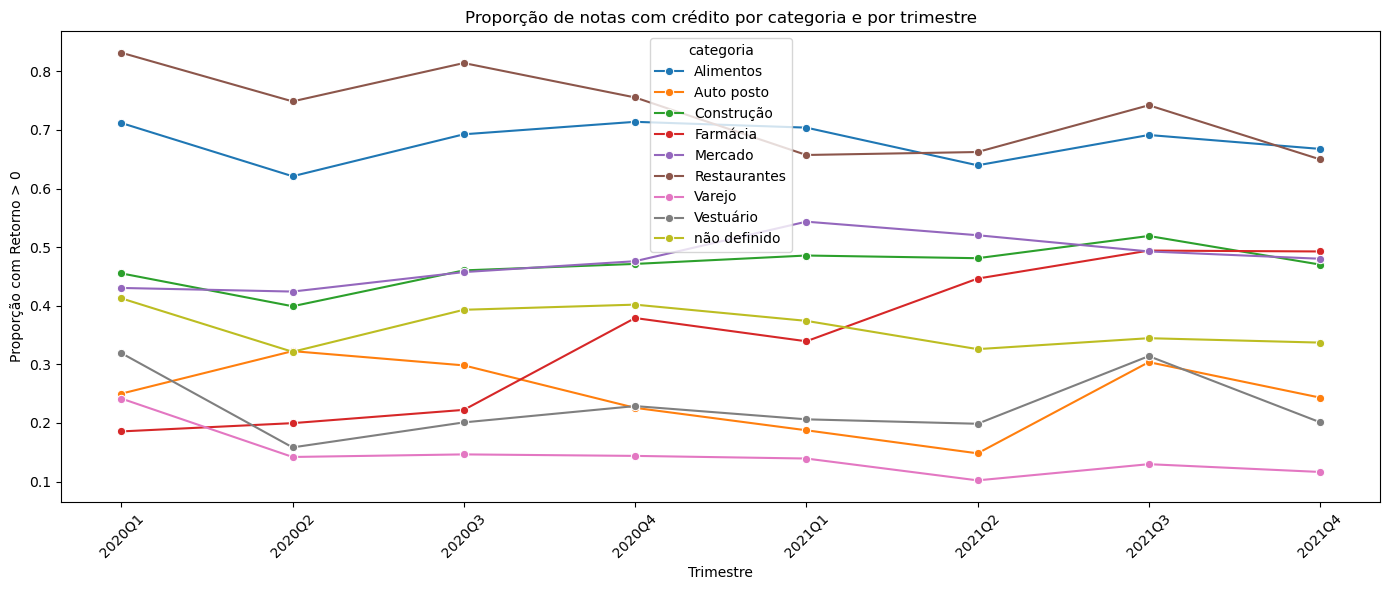

In [13]:
df['Data Emissão'] = pd.to_datetime(df['Data Emissão'], errors='coerce')

df = df[df['Data Emissão'] >= '2020-01-01'].copy()

df['trimestre'] = df['Data Emissão'].dt.to_period('Q').astype(str)

df['retorno_positivo'] = df['Retorno'] > 0

qtd_por_trimestre = df.groupby('trimestre').size()

qtd_cat_trimestre = df.groupby(['trimestre', 'categoria']).size().reset_index(name='quantidade')

proporcao_credito = (
    df.groupby(['trimestre', 'categoria'])['retorno_positivo']
    .mean()
    .reset_index(name='proporcao_com_credito')
)

plt.figure(figsize=(12, 4))
qtd_por_trimestre.plot(kind='bar')
plt.title('Quantidade total de notas por trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Quantidade de Notas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
sns.lineplot(data=qtd_cat_trimestre, x='trimestre', y='quantidade', hue='categoria', marker='o')
plt.title('Quantidade de notas por categoria e por trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Quantidade')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
sns.lineplot(data=proporcao_credito, x='trimestre', y='proporcao_com_credito', hue='categoria', marker='o')
plt.title('Proporção de notas com crédito por categoria e por trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Proporção com Retorno > 0')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

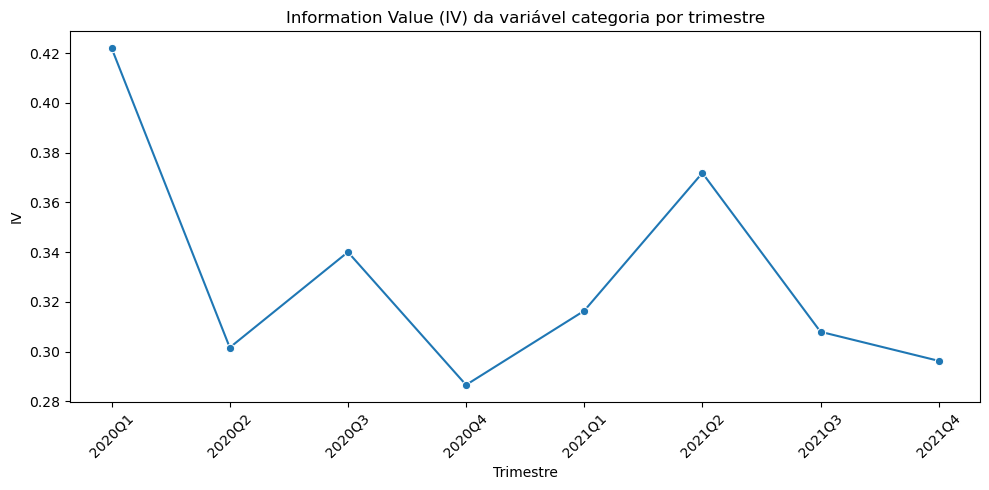

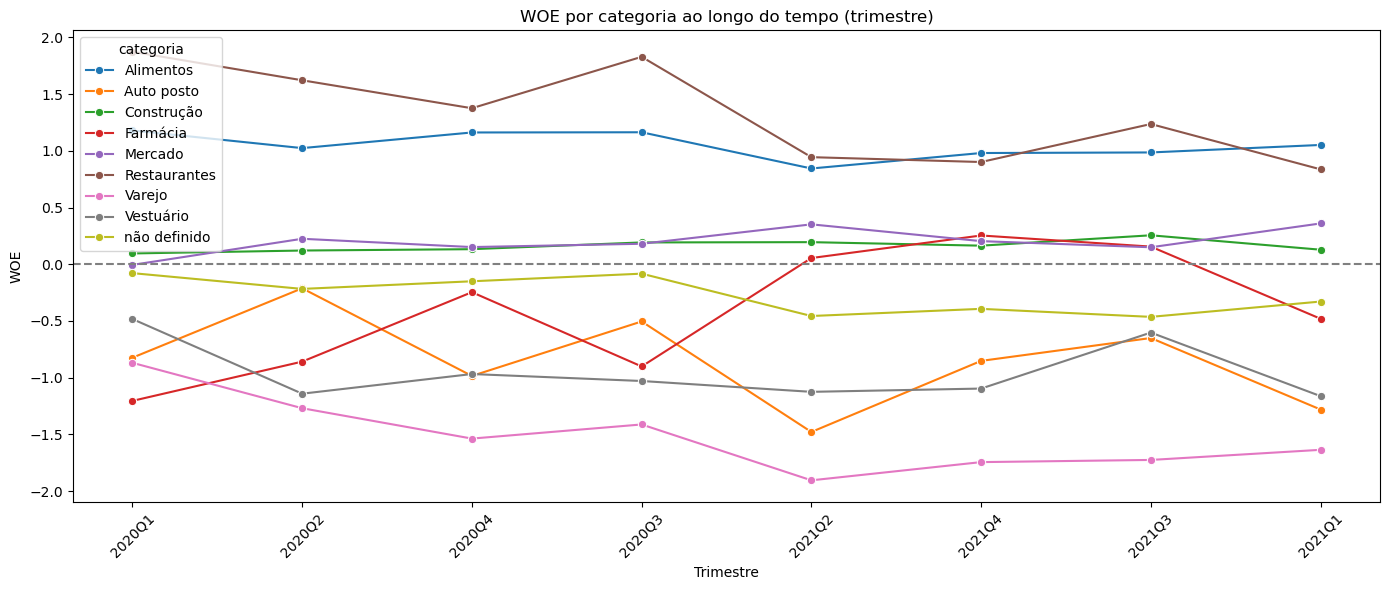

In [14]:
def calcular_woe_iv(data, feature, target):
    eps = 1e-6 
    df_woe = data.groupby(feature)[target].agg(['sum', 'count'])
    df_woe['non_event'] = df_woe['count'] - df_woe['sum']
    total_event = df_woe['sum'].sum()
    total_non_event = df_woe['non_event'].sum()
    
    df_woe['prop_event'] = df_woe['sum'] / total_event
    df_woe['prop_non_event'] = df_woe['non_event'] / total_non_event
    df_woe['WOE'] = np.log((df_woe['prop_event'] + eps) / (df_woe['prop_non_event'] + eps))
    df_woe['IV'] = (df_woe['prop_event'] - df_woe['prop_non_event']) * df_woe['WOE']
    
    return df_woe[['WOE']], df_woe['IV'].sum()

df['Data Emissão'] = pd.to_datetime(df['Data Emissão'], errors='coerce')
df = df[df['Data Emissão'] >= '2020-01-01'].copy()

df['retorno_positivo'] = df['Retorno'] > 0
df['trimestre'] = df['Data Emissão'].dt.to_period('Q').astype(str)

iv_por_trimestre = {}
woe_detalhado = {}

for t in df['trimestre'].unique():
    df_trim = df[df['trimestre'] == t]
    woe, iv = calcular_woe_iv(df_trim, 'categoria', 'retorno_positivo')
    iv_por_trimestre[t] = iv
    woe['trimestre'] = t
    woe['categoria'] = woe.index
    woe_detalhado[t] = woe.reset_index(drop=True)

df_woe_tempo = pd.concat(woe_detalhado.values())

df_iv_tempo = pd.DataFrame({
    'trimestre': iv_por_trimestre.keys(),
    'IV': iv_por_trimestre.values()
}).sort_values('trimestre')

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_iv_tempo, x='trimestre', y='IV', marker='o')
plt.title('Information Value (IV) da variável categoria por trimestre')
plt.xlabel('Trimestre')
plt.ylabel('IV')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
sns.lineplot(data=df_woe_tempo, x='trimestre', y='WOE', hue='categoria', marker='o')
plt.title('WOE por categoria ao longo do tempo (trimestre)')
plt.xlabel('Trimestre')
plt.ylabel('WOE')
plt.xticks(rotation=45)
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

In [ ]:
#As categorias que parecem ter maior proporção de notas com retornos maiores que zero são Mercado, Alimentos, Farmácia e Restaurantes. Essas categorias apresentam valores de WOE consistentemente positivos ao longo do tempo, especialmente a partir de 2020, quando o público se torna mais parecido com o atual. O Mercado se destaca com os maiores valores, seguido por Alimentos, que também mantém boa estabilidade. Farmácia e Restaurantes mostram crescimento mais gradual, mas de forma positiva. Já as categorias como Vestuário, Varejo, Auto Posto, Construção e Não Definido apresentam WOE negativo na maior parte do tempo, indicando menor proporção de retornos positivos. De modo geral, essas diferenças entre as categorias são estáveis ao longo dos trimestres analisados.